In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nfode

data = np.load('data_test.npz')
t_data = data['t_data']
x_data = data['x_data']

input_dim=2
output_dim=2
inner_dim=64
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, inner_dim)
        self.fc3 = nn.Linear(inner_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = torch.load('model.pt')
x0 = x_data[:, 0]
x_data = torch.tensor(x_data)
x_preds = nfode.predict(model, t_data, x0)
loss = nn.MSELoss()
x_preds = torch.tensor(x_preds).requires_grad_(True)

params_matrix = np.load('params_matrix.npy')

avg_distances = np.zeros(len(params_matrix))

for i in range(len(params_matrix)):
    total_distance = 0
    for j in range(len(params_matrix)):
        if i != j:  
            distance = np.linalg.norm(params_matrix[i] - params_matrix[j])
            total_distance += distance
    avg_distances[i] = total_distance / (len(params_matrix) - 1)

indices_to_remove = np.argsort(avg_distances)[-10:]

params_matrix_filtered = np.delete(params_matrix, indices_to_remove, axis=0)
from scipy.stats import multivariate_normal

mean_vector = np.mean(params_matrix_filtered, axis=0)
cov_matrix = np.cov(params_matrix_filtered, rowvar=False)

multivariate_dist = multivariate_normal(mean=mean_vector, cov=cov_matrix, allow_singular=True)

/tmp/ipykernel_43742/1642470383.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')
/tmp/ipykernel_43742/1642470383.py:34: UserWarning: To co

/home/liyilin/miniconda3/envs/gpuenv/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1000, 2])) that is different to the input size (torch.Size([1000, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201


ValueError: x and y can be no greater than 2D, but have shapes (1000,) and (1000, 1, 2)

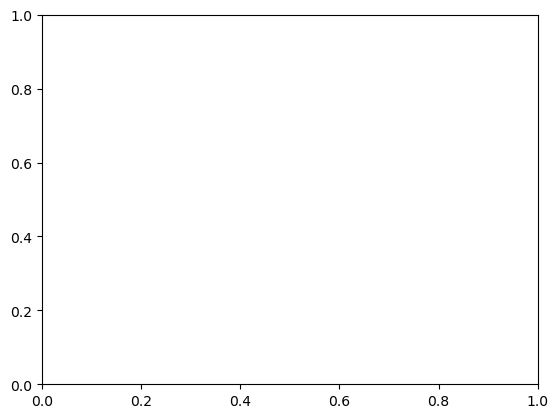

In [ ]:
loss1 = 1
epoch = 0
loss_vector = []
loss_fn = nn.MSELoss()
while (loss1>=0.2)&(epoch<=200):
    sample = multivariate_dist.rvs(size=10)
    sample = sample.reshape(-1)
    params, flat_params, param_types, param_shapes = nfode.flatten_params(model)
    modified_model = nfode.update_model_params(model, sample, param_shapes)
    x_modified_preds = nfode.predict(modified_model, t_data, x0)
    loss2 = loss_fn(x_modified_preds, x_data.T)
    if loss2 <= loss1:
        loss1 = loss2
    epoch += 1
    print(epoch)
    loss_vector.append(loss2)


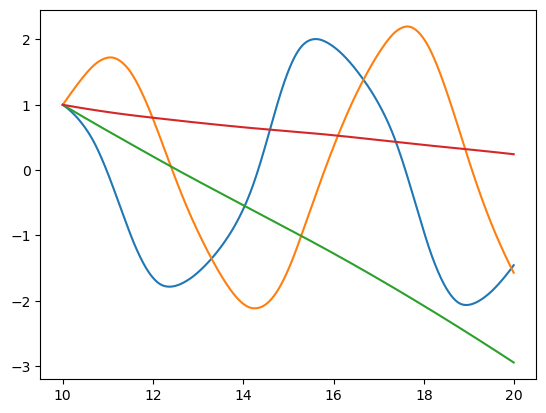

In [5]:
plt.plot(t_data, x_preds.detach().numpy().reshape(1000,2))
plt.plot(t_data, x_modified_preds.reshape(1000,2))

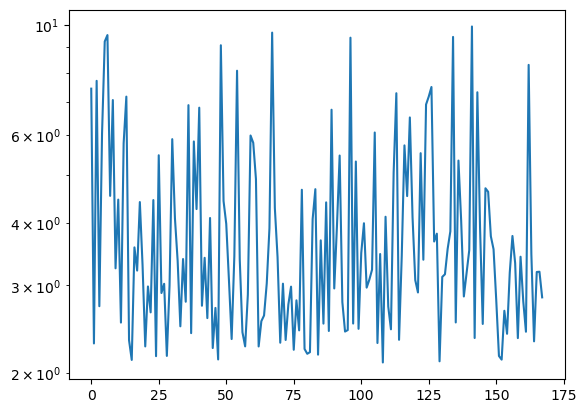

In [6]:
loss_vector = [x for x in loss_vector if x<10]
plt.plot(loss_vector)
plt.yscale('log')